# generic scikit-learn classifier

run any scikit-learn compatible classifier or list of classifiers

## steps
1. **generate a scikit-learn model configuration** using the `model_pkg_class` parameter
   * input a package and class name, for example, `sklearn.linear_model.LogisticRegression`  
   * mlrun will find the class and instantiate a copy using default parameters  
   * You can modify both the model class instantiator and the fit methods  (other functions could be similarly modified)
2. **get a sample of data** from a data source
   * select all rows using -1
   * select a random sample of rows using a negative integer
   * select consecutive rows using a positive integer
3. **split the data** into train, validation, and test sets 
   * the test set is saved as an artifact and never seen again until testing
   * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)
4. **train the model** using xgboost in one of its flavours (dask, gpu, mpi...)
5. **pickle / serialize the model**
   * models can be pickled or saved as json (a newer xgboost format)
6. **evaluate the model**
   * a custom evaluator can be provided, see function doc for details

In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "yjbds/ml-models:0.4.8"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'yjbds/ml-models:0.4.8'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import os

from cloudpickle import dumps, load, dump

from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics

from typing import List
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact

from mlrun.mlutils import (get_sample, get_splits,
                     gen_sklearn_model, create_class, eval_model_v2)
#from models import eval_class_model, log_model

def train_model(
    context: MLClientCtx,
    model_pkg_class: str,
    dataset: DataItem,
    label_column: str = "labels",
    encode_cols: List[str] = [],
    sample: int = -1,
    test_size: float = 0.30,
    train_val_split: float = 0.75,
    test_set_key: str = "test_set",
    model_evaluator = None,
    models_dest: str = "",
    plots_dest: str = "plots",
    file_ext: str = "parquet",
    model_pkg_file: str = "",
    random_state: int = 1,
) -> None:
    """train a classifier
    
    An optional cutom model evaluator can be supplied that should have the signature:
    `my_custom_evaluator(context, xvalid, yvalid, model)` and return a dictionary of 
    scalar "results", a "plots" keys with a list of PlotArtifacts, and 
    and "tables" key containing a returned list of TableArtifacts.
    
    :param context:           the function context
    :param model_pkg_class:   the model to train, e.g, "sklearn.neural_networks.MLPClassifier", 
                              or json model config
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param test_size:         (0.05) test set size
    :param train_val_split:   (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param test_set_key:      key of held out data in artifact store
    :param model_evaluator:   (None) a custom model evaluator can be specified
    :param models_dest:       ("") models subfolder on artifact path
    :param plots_dest:        plot subfolder on artifact path
    :param file_ext:          ("parquet") format for test_set_key hold out data
    :param random_state:      (1) sklearn rng seed

    """
    models_dest = models_dest or "model"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train, validate, and test sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, 1-train_val_split, random_state)
    
    # set aside some test data
    context.log_dataset(test_set_key, 
                        df=pd.concat([xtest, ytest.to_frame()], axis=1),
                        format=file_ext, index=False, 
                        labels={"data-type": "held-out"},
                        artifact_path=context.artifact_subpath('data'))

    # generate a model configuration and add CLASS and FIT params:
    model_config = gen_sklearn_model(model_pkg_class,
                                     context.parameters.items())

    # update FIT params with features and labels:
    model_config["FIT"].update({"X": xtrain,
                                "y": ytrain.values})
    
    # generate a scikit-learn class:
    ClassifierClass = create_class(model_config["META"]["class"])
    
    # instantiate the class with our updated CLASS params:
    model = ClassifierClass(**model_config["CLASS"])
    
    # and run `fit` with our updated FIT params:
    model.fit(**model_config["FIT"])
    
    # evaluate model:
    artifact_path = context.artifact_subpath(models_dest)
    plots_path = context.artifact_subpath(models_dest, plots_dest)
    if model_evaluator:
        eval_metrics = model_evaluator(context, xvalid, yvalid, model,
                                       plots_artifact_path=plots_path)
    else:
        eval_metrics = eval_model_v2(context, xvalid, yvalid, model,
                                     plots_artifact_path=plots_path)
        
    # log it all:
    context.set_label('class', model_pkg_class)
    context.log_model("model", body=dumps(model),
                      artifact_path=artifact_path,
                      extra_data=eval_metrics, 
                      model_file="model.pkl",
                      metrics=context.results,
                      labels={"class": model_pkg_class})

In [4]:
# nuclio: end-code

### sklearn trainer setup

the following task paramaters are common to all runs

In [5]:
task_params = {
    #"name" : "sklearn classifier",
    "params" : {
        "sample"             : -1,
        "test_size"          : 0.30,
        "train_val_split"    : 0.75,
        "random_state"       : 1,
        "n_jobs"             : -1,
        "plots_dest"         : "plots-p",
        "models_dest"        : 'sklearn-clfmodel'}}

models = [
    "sklearn.ensemble.RandomForestClassifier", 
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier"
]

### set model parameters and run locally

* loop over a list of candidate models, update the task and run a local trainer for that model  
* optionally customize some parameters for each model
* accumulate the resulting artifacts in a list of dicts for debugging and testing purposes  

please note that the following parameters have been chosen without regard to optimization and model tuning

In [6]:
from mlrun import mlconf

DATA_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master/" 

# choose a binary or multiclass dataset
#DATA_PATH = "sklearn_classfier/iris_dataset.csv" # MULTICLASS
DATA_PATH = "data/clf-k4-m24-n10k-imb.csv" # MULTICLASS

DATA_URL = f"{DATA_REPO}/{DATA_PATH}"

[mlrun] 2020-06-07 13:53:19,594 starting run sklearn_ensemble_RandomForestClassifier uid=73144d2ec3134874a20dd3bc77751a71  -> http://mlrun-api:8080
[mlrun] 2020-06-07 13:53:20,288 log artifact test_set at /User/artifacts/sklearn.ensemble.RandomForestClassifier/data/test_set.parquet, size: 701200, db: Y
[mlrun] 2020-06-07 13:53:21,651 log artifact confusion-matrix at /User/artifacts/sklearn.ensemble.RandomForestClassifier/model/plots/confusion-matrix.html, size: 21341, db: N
[mlrun] 2020-06-07 13:53:21,899 log artifact feature-importances at /User/artifacts/sklearn.ensemble.RandomForestClassifier/model/plots/feature-importances.html, size: 13729, db: N
[mlrun] 2020-06-07 13:53:22,020 log artifact precision-recall-multiclass at /User/artifacts/sklearn.ensemble.RandomForestClassifier/model/plots/precision-recall-multiclass.html, size: 52081, db: N
[mlrun] 2020-06-07 13:53:22,148 log artifact roc-multiclass at /User/artifacts/sklearn.ensemble.RandomForestClassifier/model/plots/roc-multicla

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...77751a71,0,Jun 07 13:53:19,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-697c84dd-kdb7xclass=sklearn.ensemble.RandomForestClassifier,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelsCLASS_max_depth=5,test-accuracy=0.7594285714285715test-error=0.24057142857142857auc-micro=0.9274749387755102auc-weighted=0.9147621747739862f1-score=0.7427369145290142precision_score=0.788830610296763recall_score=0.7180297936699329,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 73144d2ec3134874a20dd3bc77751a71 --project default , !mlrun logs 73144d2ec3134874a20dd3bc77751a71 --project default
[mlrun] 2020-06-07 13:53:22,301 run executed, status=completed
[mlrun] 2020-06-07 13:53:22,308 starting run sklearn_linear_model_LogisticRegression uid=05a493707810437facf9bb77aa085d1a  -> http://mlrun-api:8080
[mlrun] 2020-06-07 13:53:22,877 log artifact test_set at /User/artifacts/sklearn.linear_model.LogisticRegression/data/test_set.parquet, size: 701200, db: Y
[mlrun] 2020-06-07 13:53:23,064 log artifact confusion-matrix at /User/artifacts/sklearn.linear_model.LogisticRegression/model/plots/confusion-matrix.html, size: 21185, db: N
[mlrun] 2020-06-07 13:53:23,197 log artifact precision-recall-multiclass at /User/artifacts/sklearn.linear_model.LogisticRegression/model/plots/precision-recall-multiclass.html, size: 56345, db: N
[mlrun] 2020-06-07 13:53:23,326 log artifact roc-multiclass at /User/artifacts

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...aa085d1a,0,Jun 07 13:53:22,completed,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=handlerowner=adminhost=jupyter-697c84dd-kdb7xclass=sklearn.linear_model.LogisticRegression,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelsCLASS_solver=liblinear,test-accuracy=0.6931428571428572test-error=0.3068571428571429auc-micro=0.8926833197278911auc-weighted=0.8651843062073876f1-score=0.6819549980476701precision_score=0.7118088984125038recall_score=0.6622614780415241,test_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 05a493707810437facf9bb77aa085d1a --project default , !mlrun logs 05a493707810437facf9bb77aa085d1a --project default
[mlrun] 2020-06-07 13:53:23,435 run executed, status=completed
[mlrun] 2020-06-07 13:53:23,442 starting run sklearn_ensemble_AdaBoostClassifier uid=bc29560e4e7945a38710e01fb03a16dd  -> http://mlrun-api:8080
[mlrun] 2020-06-07 13:53:24,102 log artifact test_set at /User/artifacts/sklearn.ensemble.AdaBoostClassifier/data/test_set.parquet, size: 701200, db: Y
[mlrun] 2020-06-07 13:53:28,056 log artifact confusion-matrix at /User/artifacts/sklearn.ensemble.AdaBoostClassifier/model/plots/confusion-matrix.html, size: 19685, db: N
[mlrun] 2020-06-07 13:53:28,293 log artifact feature-importances at /User/artifacts/sklearn.ensemble.AdaBoostClassifier/model/plots/feature-importances.html, size: 11857, db: N
[mlrun] 2020-06-07 13:53:28,394 log artifact precision-recall-multiclass at /User/artifacts/sklearn.ensemble.A

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...b03a16dd,0,Jun 07 13:53:23,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-697c84dd-kdb7xclass=sklearn.ensemble.AdaBoostClassifier,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelsCLASS_n_estimators=200CLASS_learning_rate=0.01,test-accuracy=0.6194285714285714test-error=0.38057142857142856auc-micro=0.8505711020408163auc-weighted=0.8277751825451757f1-score=0.49466848413738246precision_score=0.7300579629393044recall_score=0.5086233408842236,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run bc29560e4e7945a38710e01fb03a16dd --project default , !mlrun logs bc29560e4e7945a38710e01fb03a16dd --project default
[mlrun] 2020-06-07 13:53:28,771 run executed, status=completed


<Figure size 432x288 with 0 Axes>

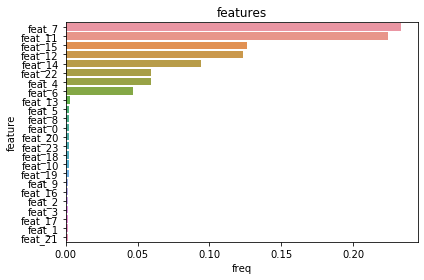

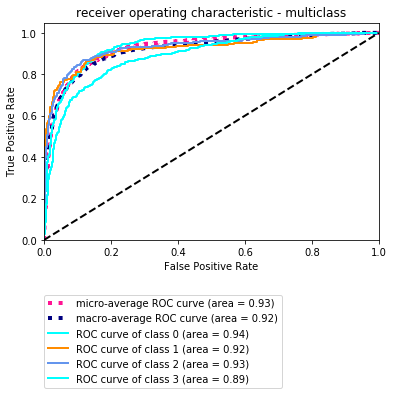

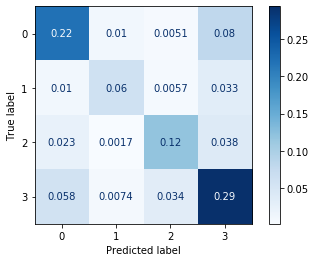

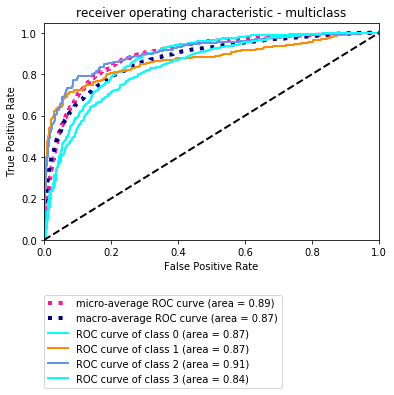

<Figure size 432x288 with 0 Axes>

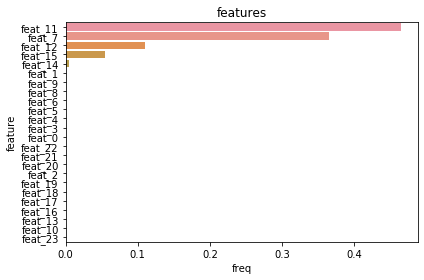

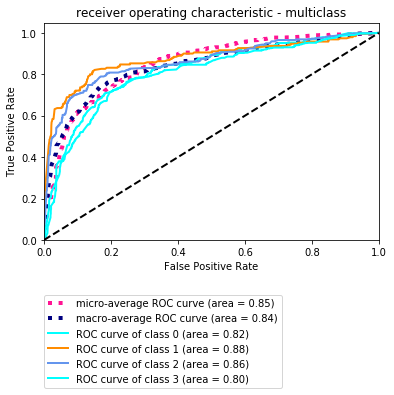

In [7]:
from mlrun import run_local, NewTask, mlconf

outputs = []
artifact_path = mlconf.artifact_path or os.path.abspath('./')
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {"params":
         { "model_pkg_class" : model,
           "label_column"    : "labels"}})
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 0.01
                                   })
    
    name = model.replace('.', '_')
    output = run_local(
        NewTask(**task_copy),
        handler=train_model,
        name=name,
        inputs={
            "dataset"  : DATA_URL
        }, artifact_path=os.path.join(artifact_path, model))
    outputs.append({name: output.outputs})


### Save

In [8]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("sklearn_classifier", handler="train_model",
                      description="train any classifier using scikit-learn's API",
                      categories=["ml", "training"],
                      labels = {"author": "yjb", "framework": "sklearn"},
                      code_output='.')

# add metadata (for templates and reuse)
fn.export("function.yaml")

[mlrun] 2020-06-07 13:53:33,620 function spec saved to path: function.yaml
